<a href="https://colab.research.google.com/github/jrojasgon/cnn-vgg-tuning-cats-dogs/blob/master/CNN_FINE_TUNE_CATS_DOGS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

In [0]:
train = !unzip '/content/drive/My Drive/Colab Notebooks/meetup-1203/cats-dogs/dataset_kaggle/train.zip'



In [0]:
test = !unzip '/content/drive/My Drive/Colab Notebooks/meetup-1203/cats-dogs/dataset_kaggle/test1.zip'

In [0]:
import glob
import numpy as np
import os
import shutil
np.random.seed(42)


cat_files = glob.glob('train/cat*')
dog_files = glob.glob('train/dog*')

len(cat_files), len(dog_files)

(12500, 12500)

In [0]:
cat_train = np.random.choice(cat_files, size=1500, replace=False)
dog_train = np.random.choice(dog_files, size=1500, replace=False)
cat_files = list(set(cat_files) - set(cat_train))
dog_files = list(set(dog_files) - set(dog_train))

cat_val = np.random.choice(cat_files, size=500, replace=False)
dog_val = np.random.choice(dog_files, size=500, replace=False)
cat_files = list(set(cat_files) - set(cat_val))
dog_files = list(set(dog_files) - set(dog_val))

cat_test = np.random.choice(cat_files, size=500, replace=False)
dog_test = np.random.choice(dog_files, size=500, replace=False)

print('Cat datasets:', cat_train.shape, cat_val.shape, cat_test.shape)
print('Dog datasets:', dog_train.shape, dog_val.shape, dog_test.shape)

Cat datasets: (1500,) (500,) (500,)
Dog datasets: (1500,) (500,) (500,)


In [0]:
train_dir = 'training_data'
val_dir = 'validation_data'
test_dir = 'test_data'

train_files = np.concatenate([cat_train, dog_train])
validate_files = np.concatenate([cat_val, dog_val])
test_files = np.concatenate([cat_test, dog_test])

os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None

for fn in train_files:
    shutil.copy(fn, train_dir)

for fn in validate_files:
    shutil.copy(fn, val_dir)
    
for fn in test_files:
    shutil.copy(fn, test_dir)

In [0]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import ntpath
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

IMG_DIM = (150, 150)

train_files = glob.glob('/content/training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [ntpath.basename(fn).split(".")[0].strip() for fn in train_files ]


validation_files = glob.glob('/content/validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [ntpath.basename(fn).split(".")[0].strip() for fn in validation_files ]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Using TensorFlow backend.


(150, 150, 3)


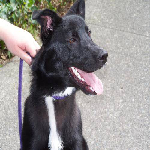

In [0]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[0].shape)
array_to_img(train_imgs[0])

In [0]:
batch_size = 30
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[1495:1505], train_labels_enc[1495:1505])

['cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'dog'] [0 0 1 0 1 1 1 0 0 1]


In [0]:
# Avec VGG 16

from keras.applications import vgg16
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

    
import pandas as pd
pd.set_option('max_colwidth', -1)

In [0]:
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])  

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f4e41d2f320>,input_2,False
1,<keras.layers.convolutional.Conv2D object at 0x7f4e41d2f3c8>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7f4e41d2f668>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7f4e38d7b8d0>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7f4e38d7b748>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7f4e38d269b0>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7f4e38d3dfd0>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7f4e38d3d9e8>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7f4e38ceec88>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7f4e38d04cc0>,block3_conv3,False


In [0]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
filepath="weights-improvement-model-vgg-tuning-{epoch:02d}-{val_acc:.2f}.hdf5"
mc = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=False)
              
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50, 
                              callbacks=[es, mc],
                              verbose=1) 


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
100/100 [==============================] - 35s 348ms/step - loss: 0.6091 - acc: 0.6517 - val_loss: 0.3248 - val_acc: 0.8790

Epoch 00001: val_acc improved from -inf to 0.87900, saving model to weights-improvement-model-vgg-tuning-01-0.88.hdf5
Epoch 2/100
100/100 [==============================] - 30s 303ms/step - loss: 0.4175 - acc: 0.8067 - val_loss: 0.3354 - val_acc: 0.8760

Epoch 00002: val_acc did not improve from 0.87900
Epoch 3/100
100/100 [==============================] - 31s 308ms/step - loss: 0.3263 - acc: 0.8567 - val_loss: 0.2066 - val_acc: 0.9169

Epoch 00003: val_acc improved from 0.87900 to 0.91692, saving model to weights-improvement-model-vgg-tuning-03-0.92.hdf5
Epoch 4/100
100/100 [==============================] - 30s 303ms/step - loss: 0.2874 - acc: 0.8840 - val_loss: 0.1872 - val_acc: 0.9210



In [0]:
# plot training
import matplotlib.pyplot as plt
import numpy as np

def plot_training(history):
    # plot the training loss and accuracy
    N = np.arange(0, len(history["loss"]))
    plt.style.use("ggplot")
    plt.figure(figsize=(20, 10))
    plt.plot(N, history["loss"], label="train_loss")
    plt.plot(N, history["val_loss"], label="test_loss")
    plt.plot(N, history["acc"], label="train_acc")
    plt.plot(N, history["val_acc"], label="test_acc")
    plt.title("Training History")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show()


plot_training(history.history)